# EDA for Rice

In [9]:
# Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
import scipy.stats as stats
from patsy import dmatrices
import numpy as np

--- EDA: Correlation Analysis of All Monthly Stressors ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

Selected 28 monthly stressor variables for correlation analysis.

Generating correlation heatmap...


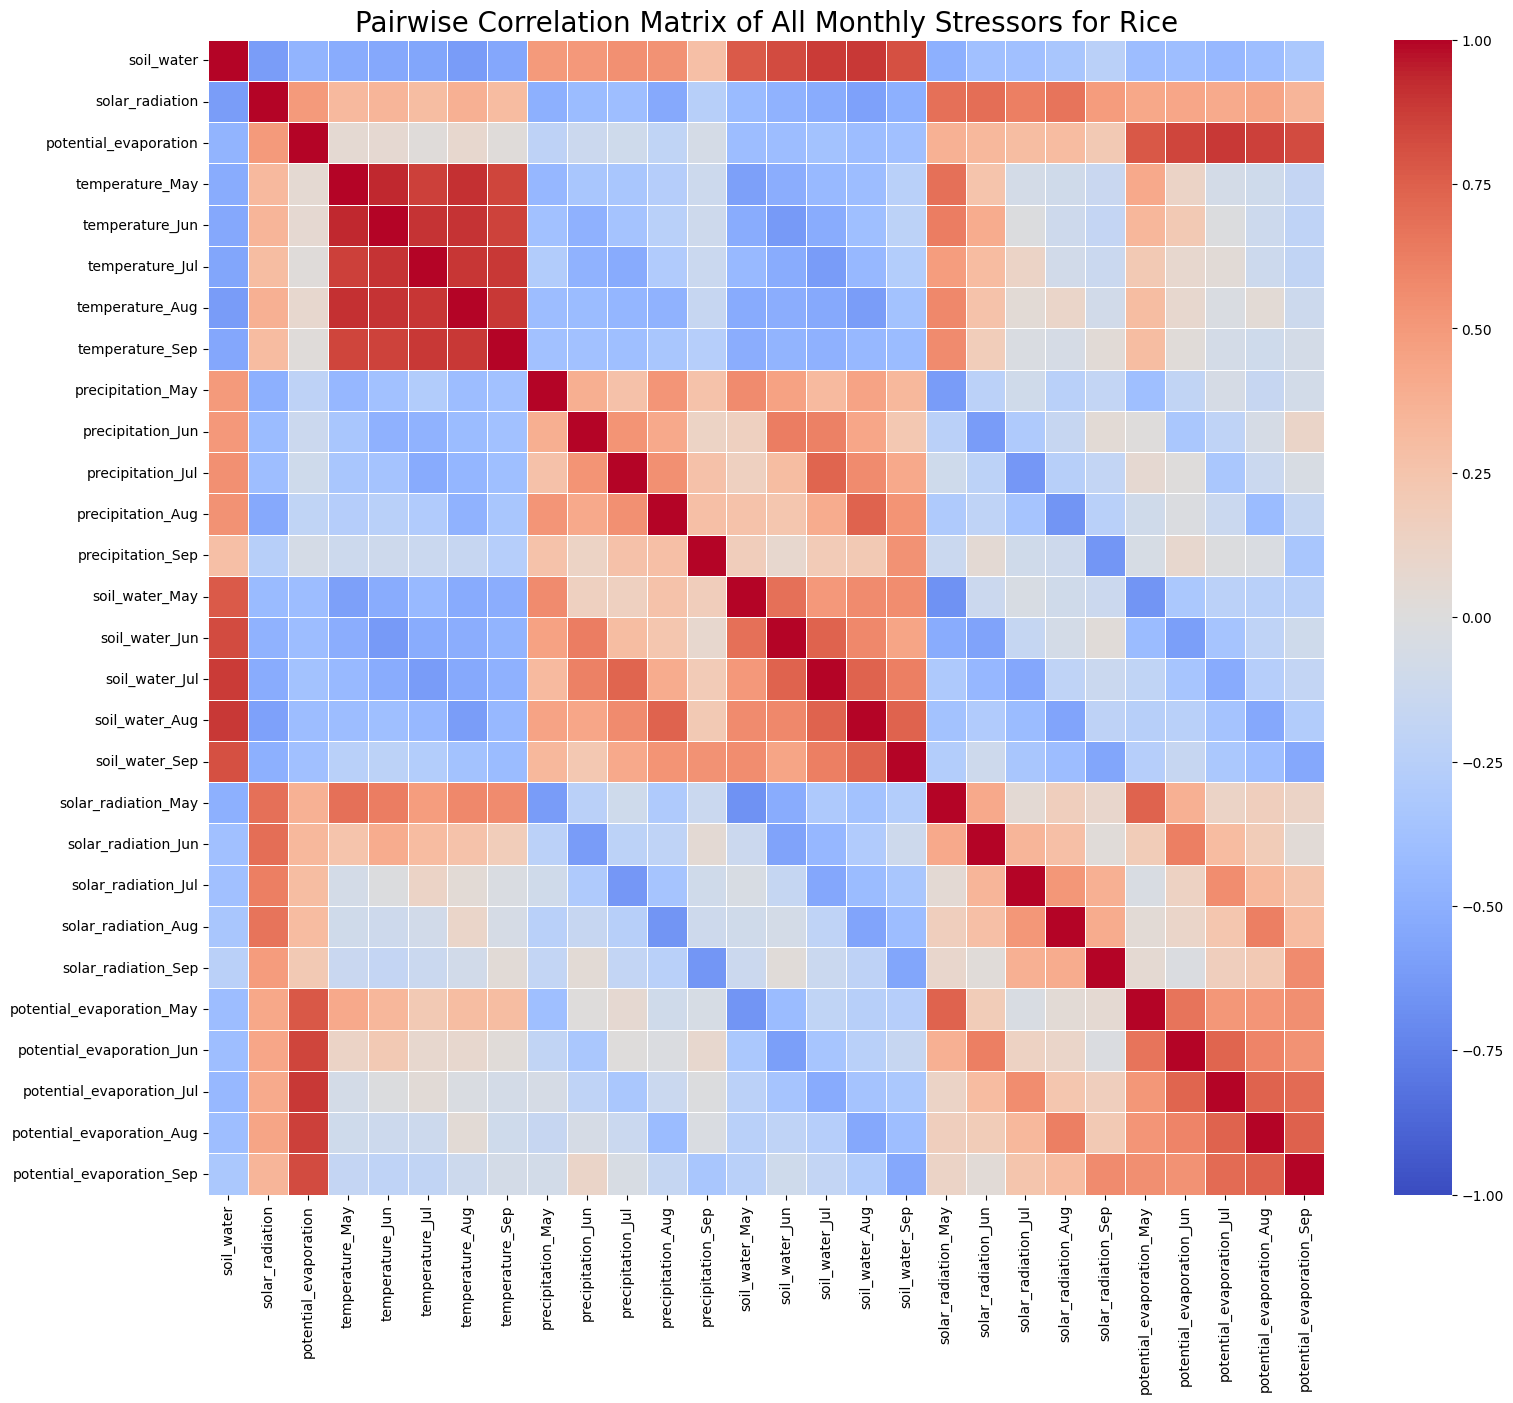

In [4]:
# Exploratory Data Analysis - Full Correlation Matrix

print("--- EDA: Correlation Analysis of All Monthly Stressors ---")

# --- 1. Load the Data ---
# As confirmed, this file is already specific to maize and its growing season.
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}")

    # --- 2. Select Only the Monthly Stressor Variables ---
    # We will select all columns that have a month name in them, which is a robust
    # way to grab all the monthly predictors we want to investigate.
    monthly_stressors = [col for col in df_maize.columns if '_' in col and 'yield' not in col]
    df_corr = df_maize[monthly_stressors]
    
    print(f"\nSelected {len(df_corr.columns)} monthly stressor variables for correlation analysis.")

    # --- 3. Calculate and Print the Correlation Matrix ---
    correlation_matrix = df_corr.corr()
    
    # Optional: If you want to see the full numerical matrix, uncomment the next line
    # print("\n--- Full Pairwise Correlation Matrix ---")
    # print(correlation_matrix)

    # --- 4. Visualize the Matrix with a Heatmap ---
    # A heatmap is the best way to see the broad patterns of collinearity.
    print("\nGenerating correlation heatmap...")
    
    plt.figure(figsize=(18, 15))
    heatmap = sns.heatmap(
        correlation_matrix,
        cmap='coolwarm',  # Use a diverging colormap (red=positive, blue=negative)
        center=0,         # Center the colormap at zero
        vmin=-1,          # Set the color scale limits to the theoretical min/max
        vmax=1,
        linewidths=.5,
        annot=False       # Annotations are turned off as the matrix is too large to be readable
    )
    
    plt.title('Pairwise Correlation Matrix of All Monthly Stressors for Rice', fontsize=20)
    plt.show()

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Extended EDA for Rice Yield Analysis ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Task 1: Analyzing the distribution of the dependent variable 'yield_rice' ---


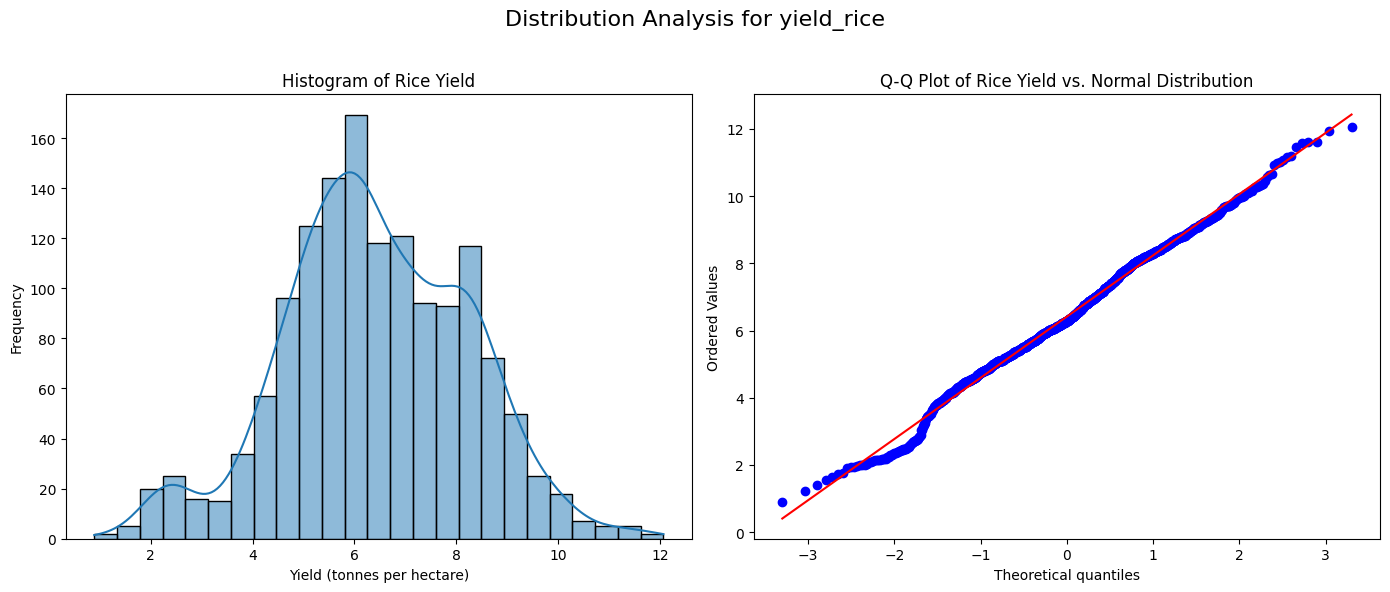

Distribution plots generated. Check for positive skew, which supports our choice of a Gamma GLM.

--- Task 2: Visualizing relationships between yield and key climate stressors ---


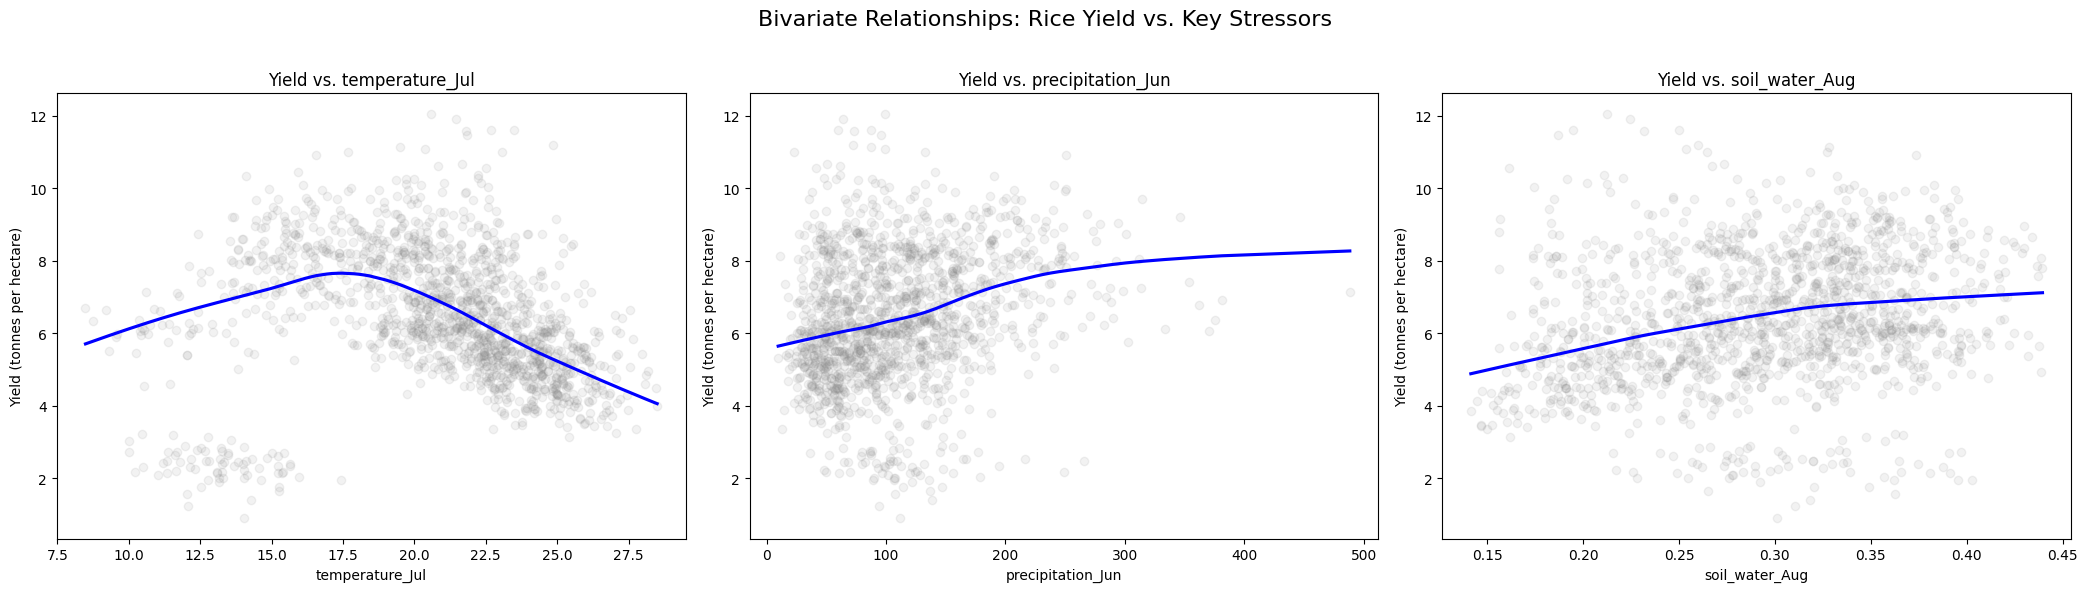

Scatter plots generated. Look for non-linear patterns that might inform our final model.

--- Task 3: Examining long-term trends in yield and a key climate variable ---


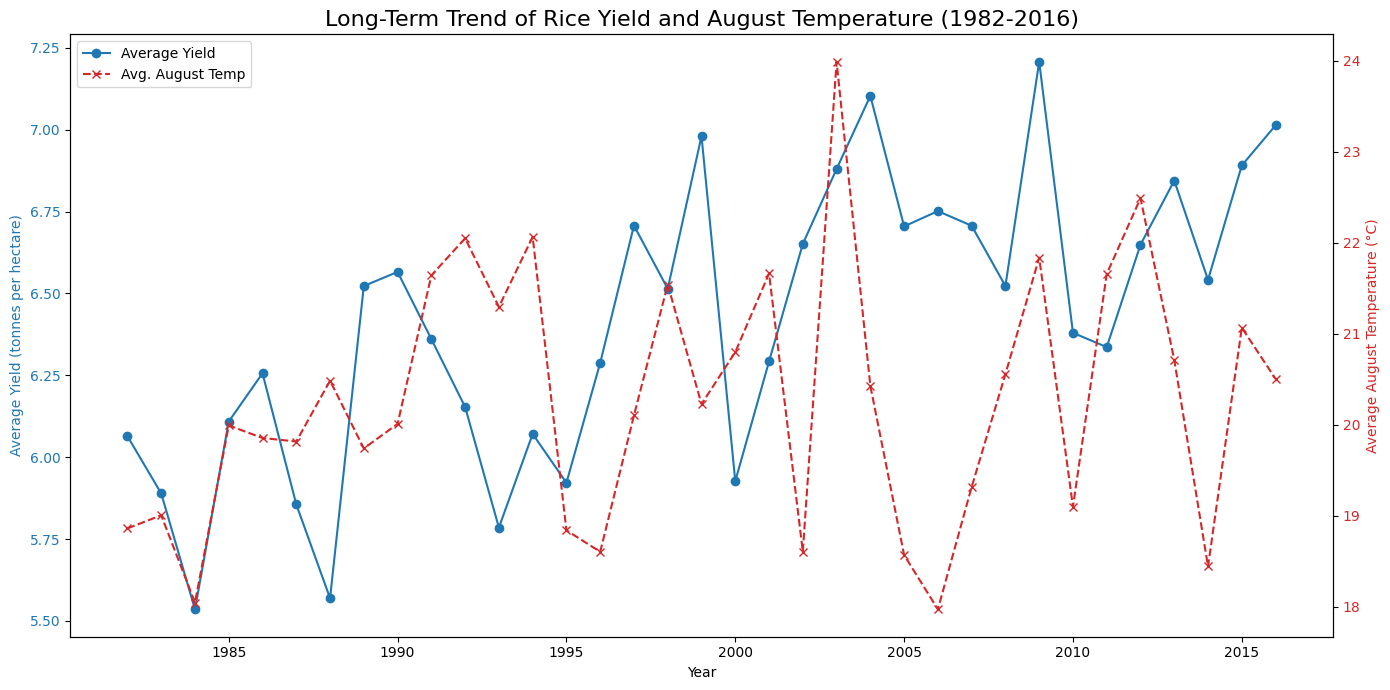

Time-series plot generated. Note the clear upward trend in yield, confirming the need for a 'year' control variable.



In [6]:
print("--- Extended EDA for Rice Yield Analysis ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- Task 1: Examine the Distribution of the Dependent Variable (yield_rice) ---
    print("--- Task 1: Analyzing the distribution of the dependent variable 'yield_rice' ---")
    
    # Create a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Distribution Analysis for yield_rice', fontsize=16)

    # a) Histogram with a Kernel Density Estimate (KDE)
    # This helps us visually assess the shape, center, and spread of the yield data.
    # We are checking for positive skewness, which is characteristic of data modeled by a Gamma distribution.
    sns.histplot(df_rice['yield_rice'], kde=True, ax=axes[0])
    axes[0].set_title('Histogram of Rice Yield')
    axes[0].set_xlabel('Yield (tonnes per hectare)')
    axes[0].set_ylabel('Frequency')

    # b) Q-Q (Quantile-Quantile) Plot against a theoretical normal distribution
    # This plot helps us assess if the data's distribution follows a specific theoretical distribution.
    # Deviations from the red line suggest skewness or heavy tails.
    # While our target is a Gamma GLM, a Q-Q plot vs. Normal is a standard first step to detect non-normality.
    stats.probplot(df_rice['yield_rice'], dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot of Rice Yield vs. Normal Distribution')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("Distribution plots generated. Check for positive skew, which supports our choice of a Gamma GLM.\n")


    # --- Task 2: Bivariate Scatter Plots of Yield vs. Key Stressors ---
    print("--- Task 2: Visualizing relationships between yield and key climate stressors ---")
    
    # Select a few key stressors based on agronomic theory for rice
    key_stressors = ['temperature_Jul', 'precipitation_Jun', 'soil_water_Aug']
    
    # Create a figure to hold the scatter plots
    fig, axes = plt.subplots(1, len(key_stressors), figsize=(21, 6))
    fig.suptitle('Bivariate Relationships: Rice Yield vs. Key Stressors', fontsize=16)

    for i, stressor in enumerate(key_stressors):
        # We use a regression plot with a LOWESS (Locally Weighted Scatterplot Smoothing) curve.
        # This is a non-parametric way to see the underlying trend without assuming a linear relationship.
        # It's excellent for spotting potential non-linearities (like an inverted 'U' shape).
        sns.regplot(
            x=stressor,
            y='yield_rice',
            data=df_rice,
            ax=axes[i],
            lowess=True, # Use LOWESS smoother to detect non-linear patterns
            scatter_kws={'alpha': 0.1, 'color': 'gray'}, # De-emphasize individual points
            line_kws={'color': 'blue'} # Emphasize the trend line
        )
        axes[i].set_title(f'Yield vs. {stressor}')
        axes[i].set_xlabel(f'{stressor}')
        axes[i].set_ylabel('Yield (tonnes per hectare)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("Scatter plots generated. Look for non-linear patterns that might inform our final model.\n")


    # --- Task 3: Plot Key Variables Over Time ---
    print("--- Task 3: Examining long-term trends in yield and a key climate variable ---")
    
    # Calculate the mean of yield and a key stressor for each year
    yearly_data = df_rice.groupby('year')[['yield_rice', 'temperature_Aug']].mean().reset_index()

    # Create a plot with a primary and secondary y-axis to show both trends together.
    # This confirms the necessity of including 'year' as a control variable to capture trends
    # likely related to technology, while also checking for climate trends.
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plotting average yield on the primary (left) y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Yield (tonnes per hectare)', color=color)
    ax1.plot(yearly_data['year'], yearly_data['yield_rice'], color=color, marker='o', label='Average Yield')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    
    # Plotting average temperature on the secondary (right) y-axis
    color = 'tab:red'
    ax2.set_ylabel('Average August Temperature (°C)', color=color)
    ax2.plot(yearly_data['year'], yearly_data['temperature_Aug'], color=color, linestyle='--', marker='x', label='Avg. August Temp')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Long-Term Trend of Rice Yield and August Temperature (1982-2016)', fontsize=16)
    fig.tight_layout()
    # Adding a single legend for both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.show()
    print("Time-series plot generated. Note the clear upward trend in yield, confirming the need for a 'year' control variable.\n")


except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except KeyError as e:
    print(f"ERROR: A required column was not found in the dataset: {e}. Please check the CSV file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Regularization

### 1. Most Important Things to Consider for Any Regularization

Regardless of the specific technique (Lasso, Ridge, or Elastic Net), there are universal principles you must always follow for the process to be valid:

1.  **Feature Scaling is Non-Negotiable:** This is the most important prerequisite. Regularization works by adding a penalty based on the size of the coefficients to the model's loss function. If your predictors are on different scales (e.g., temperature from 10-30, precipitation from 0-200), the algorithm will unfairly penalize the feature with the larger-scale coefficient, not because it's less important, but simply because its numerical value is larger. **Standardization** (scaling features to have a mean of 0 and a standard deviation of 1) is the standard procedure to ensure every variable is treated equally by the penalty.

2.  **Understand the Bias-Variance Trade-off:** The entire purpose of regularization is to manage this trade-off. A standard, unregularized model (like OLS) has low bias but can have very high variance, meaning it overfits the training data and performs poorly on new data. Regularization intentionally introduces a small amount of bias (it shrinks the coefficients, making them technically "wrong" for the training data) to achieve a massive reduction in variance. The result is a simpler, more stable model that generalizes better to unseen data.

3.  **Hyperparameter Tuning via Cross-Validation:** The strength of the regularization penalty (often denoted by `alpha` or `lambda`) is a hyperparameter that we must choose. It is never "learned" from the data directly. The only reliable way to select the optimal `alpha` is through **cross-validation (CV)**. The process involves testing a range of `alpha` values and selecting the one that results in the best model performance (e.g., lowest Mean Squared Error or Deviance) on average across all the CV folds. Flying blind and picking an arbitrary `alpha` will not produce a robust model.

4.  **Coefficients are for Selection, Not Final Interpretation:** Because the coefficients in a regularized model are shrunk (biased towards zero), their direct interpretation as "a one-unit increase in X is associated with a Y-unit change in the outcome" is complicated. The primary goal of this step is **variable selection** and identifying the most robust predictors. This is why our workflow correctly includes a final step where we refit a standard GLM using *only* the variables selected by regularization to get clean, unbiased coefficients for interpretation.

### 2. Considerations for Our Data & Necessary Manipulations

Yes, our data absolutely needs to be manipulated before we can apply regularization. Based on the principles above:

*   **Action Required:** We must **standardize all predictor variables**.
*   **Which Variables?** This includes all the monthly climate stressors (`temperature_May`, `precipitation_Jun`, etc.) as well as our `year` control variable. The `year` variable (e.g., 1982, 1983, ...) is on a much larger scale than our climate data and must be scaled to be comparable. The basis functions generated by our spatial splines (`bs(lat, df=4)`) must also be included in the standardization.
*   **What NOT to Manipulate:** We do **not** standardize the dependent variable (`yield_rice`). The model's objective is to predict the yield in its original, interpretable units (tonnes per hectare).

### 3. Best Regularization Technique for This Case: Elastic Net

For our specific project, the **Elastic Net is the superior choice**. Here is the argument comparing it to its components, Ridge and Lasso.

*   **Ridge Regression (L2 Penalty):**
    *   **How it works:** It shrinks coefficients towards zero but **never sets them to exactly zero**. It keeps all variables in the model, but reduces the impact of less important ones.
    *   **Strength:** It handles multicollinearity very well. It will tend to give correlated predictors similar coefficients.
    *   **Weakness for us:** Our goal is not just to manage collinearity, but also to perform *variable selection*. We want to identify the handful of months that are most critical. Since Ridge keeps all predictors, it doesn't help us simplify the model in this way.

*   **Lasso Regression (L1 Penalty):**
    *   **How it works:** It is capable of shrinking coefficients to **exactly zero**, effectively removing them from the model. This makes it a tool for automatic feature selection.
    *   **Strength:** It produces sparse, simpler models by identifying and eliminating irrelevant predictors.
    *   **Weakness for us:** Lasso has a major flaw when dealing with a group of highly correlated variables (like our `temperature_Jun`, `temperature_Jul`, `temperature_Aug` block). It will tend to **arbitrarily select only one** of them and zero out the others. This is unstable and undesirable. We would lose the information that the entire summer period's temperature is important, and the model might pick a different month each time it's run.

*   **Elastic Net (A mix of L1 and L2):**
    *   **How it works:** It combines both the Ridge and Lasso penalties. It has a parameter (`l1_ratio`) that lets us balance between the two.
    *   **Strength:** It inherits the best of both worlds. It can perform variable selection like Lasso, but the Ridge component allows it to handle correlated predictors gracefully. It exhibits a **"grouping effect"**: if a set of predictors are highly correlated, the Elastic Net will tend to keep or discard them as a group.
    *   **Why it's perfect for us:** Our EDA heatmap showed us that our data is defined by highly correlated blocks of variables. The Elastic Net is specifically designed for this scenario. It will allow us to both select the most important *groups* of stressors and shrink the coefficients within those groups, giving us a stable, interpretable, and robust selection of variables to carry forward to our final explanatory model.

Therefore, our plan to use the Elastic Net is not just a good choice; it is the **theoretically correct and most robust choice** for the structure of our data and the goals of our project.

In [8]:
# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}")

    # --- 2. Define the Full Model Formula ---
    # Programmatically get all monthly stressor column names
    monthly_stressors = [col for col in df_rice.columns if '_' in col and 'yield' not in col]
    
    # Join them with '+' to create the predictor part of the formula
    stressor_formula_part = ' + '.join(monthly_stressors)
    
    # Construct the complete R-style formula string.
    # We include our controls (year, spatial splines) and all potential predictors.
    # Note: patsy's bs() function creates the basis spline columns.
    formula = f"yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + {stressor_formula_part}"
    
    print("\nGenerated model formula for patsy:")
    print(formula) # Uncomment to see the full, very long formula string

    # --- 3. Create the Design Matrix (X) and Response Vector (y) ---
    # patsy processes the formula and the dataframe to create the matrices needed for modeling.
    # 'y' will be our dependent variable, 'X' will be the full set of predictors.
    # The intercept is automatically included in 'X' by patsy.
    print("\nCreating design matrix (X) and response vector (y) using patsy...")
    y, X = dmatrices(formula, data=df_rice, return_type='dataframe')
    
    print(f"Successfully created response vector y with shape: {y.shape}")
    print(f"Successfully created design matrix X with shape: {X.shape}")
    print(f"The {X.shape[1]} columns in X include the intercept, year, 8 spline bases (4 for lat, 4 for lon), and {len(monthly_stressors)} climate stressors.")

    # --- 4. Standardize the Predictor Matrix (X) ---
    # This is the critical step we discussed. We scale ALL predictors to have a mean of 0 and a standard deviation of 1.
    # This ensures the regularization penalty is applied fairly to all variables.
    # We do NOT scale the response variable y.
    print("\nStandardizing the design matrix X...")
    
    # We remove the Intercept column before scaling, as it should not be regularized or scaled.
    # We will add it back later if needed, but scikit-learn's models handle it by default.
    X_no_intercept = X.drop('Intercept', axis=1)
    
    scaler = StandardScaler()
    X_scaled_values = scaler.fit_transform(X_no_intercept)
    
    # Convert the scaled array back to a pandas DataFrame with the original column names
    X_scaled = pd.DataFrame(X_scaled_values, columns=X_no_intercept.columns, index=X.index)
    
    print("Standardization complete.")
    
    # Verification: Check the mean and standard deviation of a few scaled columns
    print("\n--- Verification of Standardization ---")
    verification_cols = ['year', 'bs(lat, df=4)[0]', 'temperature_Jul']
    for col in verification_cols:
        mean_val = X_scaled[col].mean()
        std_val = X_scaled[col].std()
        print(f"Column '{col}': Mean = {mean_val:.4f}, Std Dev = {std_val:.4f}")
    print("------------------------------------")
    

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

Generated model formula for patsy:
yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + soil_water + solar_radiation + potential_evaporation + temperature_May + temperature_Jun + temperature_Jul + temperature_Aug + temperature_Sep + precipitation_May + precipitation_Jun + precipitation_Jul + precipitation_Aug + precipitation_Sep + soil_water_May + soil_water_Jun + soil_water_Jul + soil_water_Aug + soil_water_Sep + solar_radiation_May + solar_radiation_Jun + solar_radiation_Jul + solar_radiation_Aug + solar_radiation_Sep + potential_evaporation_May + potential_evaporation_Jun + potential_evaporation_Jul + potential_evaporation_Aug + potential_evaporation_Sep

Creating design matrix (X) and response vector (y) using patsy...
Successfully created response vector y with shape: (1435, 1)
Successfully created design matrix X with shape: (1435, 38)
The 38 columns in X include the 

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Successfully initialized Gamma GLM with a log link.
Will fit the model for 100 alpha values with L1_wt (l1_ratio) = 0.5


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")



Completed fitting models along the regularization path.
Generating the regularization path plot...


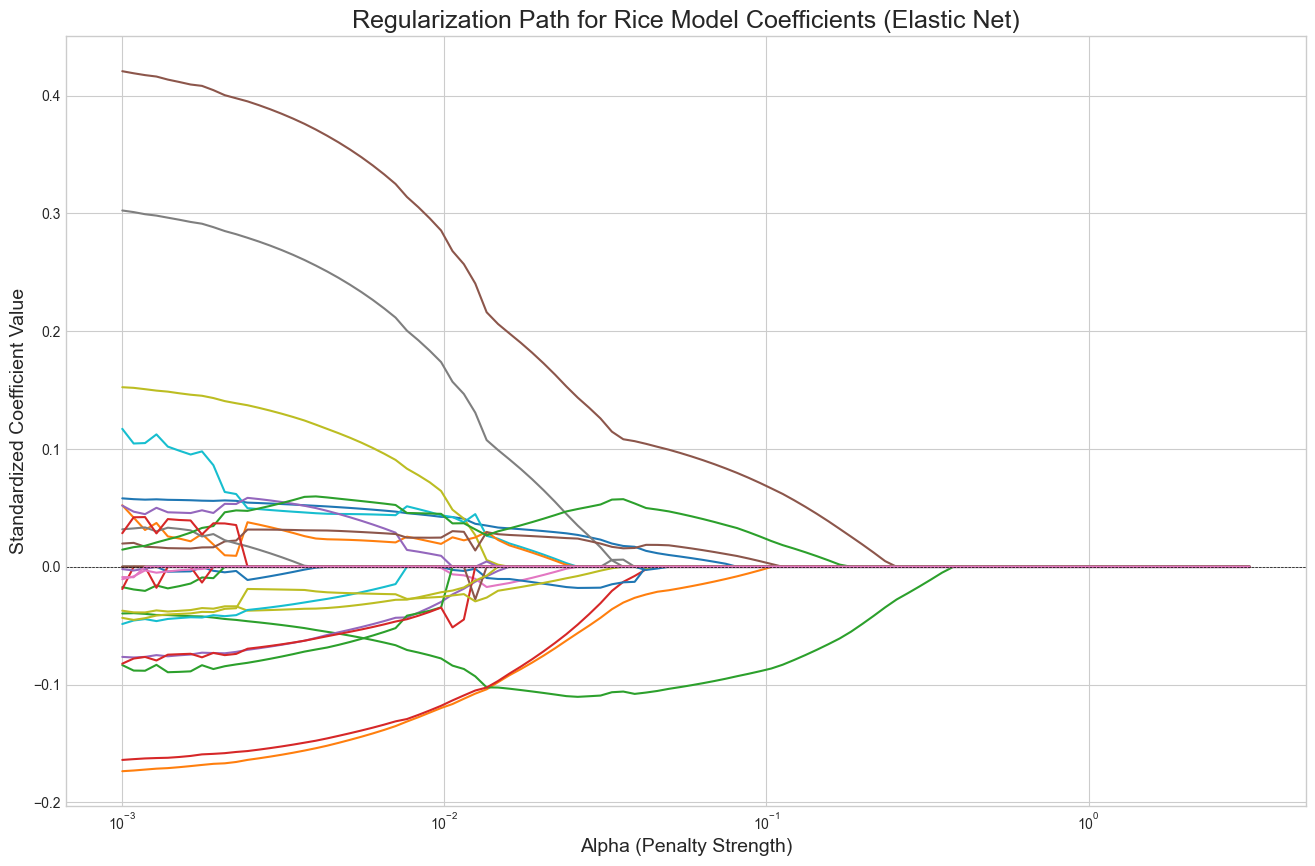

In [10]:
# We assume 'y' and 'X_scaled' are already in memory from the previous step.
# If not, you would need to re-run the data preparation script.

try:
    # --- 1. Define the GLM Model ---
    # We specify our model family (Gamma) and the link function (log) as per our project plan.
    # We pass the prepared y and the fully scaled X matrix.
    # Note: statsmodels requires the intercept to be in the X matrix, which patsy provided.
    
    # We need to add the intercept back to the scaled data for statsmodels GLM
    X_scaled_with_intercept = X.copy() # Start with the original X to preserve intercept and structure
    X_scaled_with_intercept[X_no_intercept.columns] = X_scaled # Replace non-intercept columns with scaled versions

    gl_gamma = sm.GLM(y, X_scaled_with_intercept, family=sm.families.Gamma(link=sm.families.links.log()))
    print("Successfully initialized Gamma GLM with a log link.")

    # --- 2. Set up the Regularization Path ---
    # We need to test a series of alpha values (penalty strengths).
    # A logarithmic scale is best for this, from a weak penalty to a strong one.
    n_alphas = 100
    alphas = np.logspace(-3, 0.5, n_alphas) # From 0.001 to ~3.16

    # The L1_wt parameter controls the Elastic Net mix (0=Ridge, 1=Lasso). 
    # 0.5 is a balanced choice.
    elastic_net_l1_wt = 0.5 
    
    print(f"Will fit the model for {n_alphas} alpha values with L1_wt (l1_ratio) = {elastic_net_l1_wt}")

    # --- 3. Fit the Model for Each Alpha and Store Coefficients ---
    # We will loop through our alphas and save the coefficients from each model fit.
    coefficients = []
    
    for alpha_val in alphas:
        # The fit_regularized method performs the Elastic Net estimation.
        # We set refit=False because we want to see the shrunken coefficients for this analysis.
        results = gl_gamma.fit_regularized(
            method='elastic_net', 
            alpha=alpha_val, 
            L1_wt=elastic_net_l1_wt,
            refit=False 
        )
        coefficients.append(results.params)
    
    # Convert the list of coefficient series into a DataFrame for easy plotting
    coef_df = pd.DataFrame(coefficients, index=alphas)
    coef_df.index.name = "alpha"
    
    # Exclude the Intercept for plotting, as it's not regularized and has a different scale.
    coef_df_no_intercept = coef_df.drop('Intercept', axis=1)
    
    print("\nCompleted fitting models along the regularization path.")

    # --- 4. Visualize the Regularization Path ---
    print("Generating the regularization path plot...")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 10))

    ax.plot(coef_df_no_intercept)
    ax.set_xscale('log') # The alpha path is best viewed on a log scale
    
    # Add a vertical line at zero
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    ax.set_title('Regularization Path for Rice Model Coefficients (Elastic Net)', fontsize=18)
    ax.set_xlabel('Alpha (Penalty Strength)', fontsize=14)
    ax.set_ylabel('Standardized Coefficient Value', fontsize=14)
    
    # To avoid a cluttered legend, we don't add one here. The goal is to see the general pattern.
    # Alternatively, for fewer variables, a legend could be useful:
    # ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

    plt.show()

except NameError:
    print("ERROR: Make sure that 'y' and 'X_scaled' DataFrames from the previous step are available in memory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [12]:
# --- Corrected code to identify the most robust variables ---
# We will inspect the coefficients at a moderately high alpha value
# This tells us which variables "survived" the penalty the longest.
alpha_to_inspect = 0.03 

try:
    # Find the alpha in our index that is closest to our target
    # CORRECTED LINE: The operation works directly on the index without .flat
    closest_alpha = coef_df.index[np.abs(coef_df.index - alpha_to_inspect).argmin()]

    print(f"--- Coefficients at alpha ≈ {closest_alpha:.4f} ---")

    # Get the coefficients at this alpha and sort them by absolute value
    robust_coeffs = coef_df.loc[closest_alpha].copy()
    robust_coeffs_sorted = robust_coeffs.abs().sort_values(ascending=False)

    print("\nVariables sorted by the absolute magnitude of their shrunken coefficient:")
    # We display more variables to get a fuller picture
    print(robust_coeffs_sorted.head(15))

    # Let's also see their actual values (positive or negative) for the top variables
    print("\n--- Actual coefficient values for the most robust variables ---")
    print(coef_df.loc[closest_alpha, robust_coeffs_sorted.index].head(10))

except NameError:
     print("ERROR: Make sure that 'coef_df' DataFrame from the previous step is available in memory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Coefficients at alpha ≈ 0.0305 ---

Variables sorted by the absolute magnitude of their shrunken coefficient:
Intercept                    1.796332
bs(lon, df=4)[0]             0.125921
bs(lat, df=4)[1]             0.109365
potential_evaporation_May    0.052873
bs(lat, df=4)[0]             0.043349
bs(lat, df=4)[2]             0.030923
year                         0.023032
soil_water_Aug               0.019680
solar_radiation              0.017756
bs(lon, df=4)[2]             0.016489
solar_radiation_Jun          0.003300
bs(lat, df=4)[3]             0.000000
bs(lon, df=4)[3]             0.000000
bs(lon, df=4)[1]             0.000000
temperature_Jun              0.000000
Name: 0.030538555088334154, dtype: float64

--- Actual coefficient values for the most robust variables ---
Intercept                    1.796332
bs(lon, df=4)[0]             0.125921
bs(lat, df=4)[1]            -0.109365
potential_evaporation_May    0.052873
bs(lat, df=4)[0]            -0.043349
bs(lat, df=4)[2]  

In [14]:
print("--- Fitting the Base Champion Model ---")

# --- 1. Load the Data ---
# We use the original dataframe for this step.
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Champion Model ---
    # This formula contains only the variables that proved robust in the regularization step.
    # We use statsmodels.formula.api which simplifies fitting models from a formula string.
    champion_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water_Aug + solar_radiation"

    # Initialize the GLM model using the formula and the dataframe.
    # Specify the Gamma family with a log link as planned.
    base_model = smf.glm(
        formula=champion_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model. This is the standard, un-penalized fit.
    base_model_results = base_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    # This summary is now statistically valid and is the basis for our interpretation.
    print("--- Summary of the Base Champion Model ---")
    print(base_model_results.summary())

    # --- 4. Print AIC for Future Comparison ---
    # The AIC is a key metric for comparing different model formulations. Lower is better.
    print("\n" + "="*80)
    print(f"AIC for Base Champion Model: {base_model_results.aic:.2f}")
    print("This will be our benchmark for comparison.")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Fitting the Base Champion Model ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Base Champion Model ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1422
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                        0.042897
Method:                          IRLS   Log-Likelihood:                -2407.6
Date:                Wed, 12 Nov 2025   Deviance:                       63.892
Time:                        00:04:24   Pearson chi2:                     61.0
No. Iterations:                    16   Pseudo R-squ. (CS):             0.6988
Covariance Type:            nonrobust                                         
            

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### interpretation comments:

1. The solar_radiation coef is tiny. The coefficient of -5.25e-10 means that for a one-unit increase in solar_radiation, the log of yield decreases by that amount. The units of solar radiation are very large. A "one-unit" increase is a physically meaningless, tiny change. Because a single unit change is so small, the coefficient associated with it must also be minuscule. What matters is its sign (negative) and its p-value (0.000). The model is telling us with very high confidence that there is a real, negative relationship. 

2. The soil_water_Aug coef is large. The units for soil_water_Aug are a proportion or a percentage (e.g., ranging from 0.1 to 0.5, representing 10% to 50% volumetric water content). A "one-unit increase" in this variable would be a massive change (e.g., from 0.2 to 1.2), which is often physically impossible.

3. Our model explains almost 70% of the variation in rice yield. 

4. Control Variables
    *   `year`: The coefficient is positive and highly significant (p=0.000). For each passing year, yield increases by about 0.48% (`e^0.0048 ≈ 1.0048`), confirming a strong technological trend.
    *   `bs(lat, df=4)` & `bs(lon, df=4)`: As a group, these are overwhelmingly significant. This confirms our earlier finding: **geography is a dominant driver of rice yield.**

5. Climate Stressors
    *   `potential_evaporation_May`: Positive and highly significant (p=0.000). Higher potential evaporation in May (proxy for sun and warmth) is associated with higher yields, likely by promoting strong early plant growth.
    *   `soil_water_Aug`: Positive and highly significant (p=0.000). More available water in the soil during the critical grain-filling month of August is strongly associated with higher yields. This makes perfect agronomic sense.
    *   `solar_radiation`: Negative and highly significant (p=0.000). After controlling for everything else, higher season-average solar radiation (a proxy for overall heat/sun stress) is associated with lower yields.


## plan for testing the following things to see if they improve our model:

1. Add a quadratic (squared) term for the most influential climate variables identified in the base model. This would be I(potential_evaporation_May**2)

2. Add an interaction term between the two most plausible climate variables. Something like soil_water_Aug * solar_radiation

3. Fit an alternative model where the aggregate solar_radiation is replaced by its most likely monthly counterpart (e.g., solar_radiation_Jul or solar_radiation_Aug).

4. Identify the "first variable to be eliminated" from our regularization path and add it back into our champion model to see if it contributes meaningfully. I am not sure tho if this is worth it. 

## Add a quadratic (squared) term for the most influential climate variables identified in the base model. This would be I(potential_evaporation_May**2)

In [15]:
print("--- Testing for Non-Linearity (Quadratic Term) ---")
print("--- Model with squared term for potential_evaporation_May ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Model with a Quadratic Term ---
    # We add I(potential_evaporation_May**2) to test for a non-linear, U-shaped effect.
    # The I() function ensures that the squaring operation is performed mathematically.
    quadratic_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation"

    # Initialize the GLM model using the new formula.
    quadratic_model = smf.glm(
        formula=quadratic_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    quadratic_model_results = quadratic_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Model with Quadratic Term ---")
    print(quadratic_model_results.summary())

    # --- 4. Print AIC for Comparison ---
    # We will compare this AIC to the Base Champion Model's AIC. A lower value indicates a better model.
    print("\n" + "="*80)
    print(f"AIC for Quadratic Model: {quadratic_model_results.aic:.2f}")
    print("Compare this to the Base Champion Model's AIC.")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Testing for Non-Linearity (Quadratic Term) ---
--- Model with squared term for potential_evaporation_May ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Model with Quadratic Term ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1421
Model Family:                   Gamma   Df Model:                           13
Link Function:                    log   Scale:                        0.041909
Method:                          IRLS   Log-Likelihood:                -2393.9
Date:                Wed, 12 Nov 2025   Deviance:                       62.687
Time:                        00:09:22   Pearson chi2:                     59.6
No. Iterations:                    24   Pseudo R-squ. (CS):             0.7130
Covariance T

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### interpretations

Looking at the potential_evaporation_May coef, it is now negative, meanwhile the I(potential_evaporation_May ** 2) is positive. This combination describes a U-shaped curve that opens upwards. 

At low levels of potential evaporation in May, increasing it seems to have a small negative effect on yield. This could be because very low potential evaporation is associated with cold, damp, overcast conditions which are not ideal for newly established rice plants. However, once potential evaporation crosses a certain threshold, the positive squared term begins to dominate, and its effect becomes strongly positive. This aligns with the idea that sunny, warm conditions in May promote vigorous growth that leads to higher yields. 

We also tested to see if adding a double quadratic term (current model plus I(soil_water_Aug ** 2)), which gave us a model that had an AIC of 4817.59. Adding I(soil_water_Aug ** 2) was also not significant with a pval of >0.6. So we rejected this new model and are continuing with the previous one (the one above). 

## Add an interaction term between the two most plausible climate variables. Something like soil_water_Aug * solar_radiation

We want to look at interractions that are plausible from an agronomic or physical standpoint.

1.  **Hypothesis 1 (Water & Sun - MOST PLAUSIBLE):** The effect of ample `soil_water_Aug` on yield is *stronger* during seasons with very high `solar_radiation` (i.e., high heat and sun stress). In other words, water is more valuable when it's hot and sunny. This is a classic and highly plausible interaction.
    *   **Formula Term:** `soil_water_Aug:solar_radiation`

2.  **Hypothesis 2 (Early Growth & Water):** This is the one you proposed. The benefit of `soil_water_Aug` depends on the `potential_evaporation_May`. This is also plausible. A plant that established well in May (good conditions) might be able to utilize August water more efficiently.
    *   **Formula Term:** `potential_evaporation_May:soil_water_Aug`

In [17]:
print("--- Testing for Interaction Effect (Water x Sun) ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Model with the Interaction Term ---
    # We build on our best model by adding a single, agronomically-plausible interaction.
    interaction_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation + soil_water_Aug:solar_radiation"

    # Initialize the GLM model using the new formula.
    interaction_model = smf.glm(
        formula=interaction_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    interaction_model_results = interaction_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Model with Interaction Term ---")
    print(interaction_model_results.summary())

    # --- 4. Print AIC for Comparison ---
    # We will compare this AIC to our current champion model's AIC (4815.85).
    print("\n" + "="*80)
    print(f"AIC for Interaction Model: {interaction_model_results.aic:.2f}")
    print("Compare this to the Quadratic Model's AIC (4815.85).")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Testing for Interaction Effect (Water x Sun) ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Model with Interaction Term ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1420
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                        0.041977
Method:                          IRLS   Log-Likelihood:                -2392.8
Date:                Wed, 12 Nov 2025   Deviance:                       62.600
Time:                        00:34:36   Pearson chi2:                     59.6
No. Iterations:                   100   Pseudo R-squ. (CS):             0.7129
Covariance Type:            nonrobust                                 

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### interpretations and questions

Okay. The new additions arent significant. So we reject the model (Aic score is really not that different at all). Our model also became unstable. So our best model is still the: 

yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation

Would it be worth to look into if the specific solar_radiation_Jul/Jun/May... had an effect here instead of a growing season average? Or do we simply move on? Our idea was to take the current best model which uses solar_radiation and replace it with each of the solar_radiation_month to test the monthly alternatives. And if there is an alternative that is just as good or better, we could retry the interraction term? 